<a href="https://colab.research.google.com/github/miguelamda/gtc2017-numba/blob/master/2%20-%20CUDA%20Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Conceptos Básicos De CUDA

![image](https://www.nvidia.com/content/dam/en-zz/Solutions/gtcDC/training/nvidia-dli-workshop-cuda-3c33-l@1x.jpg)

Existen dos aproximaciones básicas a la programación de GPUs con Numba:

 1. ufuncs/gufuncs (lo veremos en esta sección)
 2. CUDA Python kernels (lo veremos en una posterior sección)
 
Recuerda que el hardware subyacente a CUDA está diseñado para el *paralelismo de datos*.  El máximo rendimiento se logra cuando se computan las mismas operaciones en muchos elementos diferentes a la vez.  Las funciones universales son paralelas de datos de manera natural. Empezaremos con estas funciones.

Antes de nada, usemos el siguiente comando para ver qué GPU tenemos asignada. Si estamos en Google Colab, debemos solicitar una, yendo a *Entorno de ejecución -> Cambiar tipo de entorno de ejecución*.

In [3]:
!nvidia-smi

Fri Apr 24 09:58:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## 1.1. Funciones Universales

NumPy tiene el concepto de funciones universales (*universal functions*, o "ufuncs"), las cuales son funciones que pueden tomar arrays de NumPy de varias dimensiones (o escalares) y operar en ellas, elemento por elemento.

Mejor veamos qué sucede con un ejemplo. Usemos la ufunc `add` de NumPy para demostrar qué pasa:

In [1]:
import numpy as np

a = np.array([1, 2, 3, 4])
b = np.array([10, 20, 30, 40])

np.add(a, b)

array([11, 22, 33, 44])

Las ufuncs también pueden combinar escalares con arrays:

In [4]:
np.add(a, 100)

array([101, 102, 103, 104])

También se pueden combinar arrays de dimensiones diferentes, pero compatibles.  El array de dimensiones inferiores se replicará para que coincida con la dimensionalidad del array de dimensiones superiores (también conocido como *broadcasting*).

In [5]:
c = np.arange(4*4).reshape((4,4))
print('c:', c)

np.add(b, c)

c: [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


array([[10, 21, 32, 43],
       [14, 25, 36, 47],
       [18, 29, 40, 51],
       [22, 33, 44, 55]])

En la situación anterior, la matriz `b` se añade a cada fila de `c`.  Si queremos añadir `b` a cada columna, tenemos que transponerla.  Hay varias maneras de hacerlo, pero una de ellas es insertar un nuevo eje usando `np.newaxis`:

In [6]:
b_col = b[:, np.newaxis]
b_col

array([[10],
       [20],
       [30],
       [40]])

In [7]:
np.add(b_col, c)

array([[10, 11, 12, 13],
       [24, 25, 26, 27],
       [38, 39, 40, 41],
       [52, 53, 54, 55]])

La documentación de NumPy contiene más información exhaustiva de las ufuncs:

https://numpy.org/doc/stable/reference/ufuncs.html

## 1.2 Construyendo Ufuncs Para La GPU

Numba tiene la capacidad de crear ufuncs compilados. Si tú implementas una función escalar para todas las entradas, y Numba averiguará las reglas de broadcast por tí.  Generar un ufunc que utilice CUDA requiere dar una signatura de tipos explícita y establecer el atributo `target`:

In [0]:
from numba import vectorize

@vectorize(['int64(int64, int64)'], target='cuda')
def add_ufunc(x, y):
    return x + y

In [9]:
print('a+b:\n', add_ufunc(a, b))
print()
print('b_col + c:\n', add_ufunc(b_col, c))

a+b:
 [11 22 33 44]

b_col + c:
 [[10 11 12 13]
 [24 25 26 27]
 [38 39 40 41]
 [52 53 54 55]]


¡Acaban de pasar muchas cosas! Numba automáticamente:

 * Compiló un kernel CUDA para ejecutar la operación ufunc en paralelo sobre todos los elementos de entrada.
 * Asignó memoria de GPU para las entradas y la salida.
 * Copió los datos de entrada a la GPU.
 * Ejecutó el kernel CUDA con las dimensiones correctas del kernel dados los tamaños de entrada.
 * Copió el resultado de la GPU a la CPU.
 * Devolvió el resultado como un array NumPy en el host.

Esto es muy conveniente para hacer pruebas, pero copiar los datos de ida y vuelta entre la CPU y la GPU puede ser lento y perjudicar el rendimiento.  En el próximo notebook aprenderás sobre la administración de devices y la asignación de memoria.

Tal vez te preguntes cómo de rápido es nuestro sencillo ejemplo en la GPU.  Veamos:


In [10]:
%timeit np.add(b_col, c)   # NumPy en CPU

The slowest run took 34.73 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.17 µs per loop


In [11]:
%timeit add_ufunc(b_col, c) # Numba en GPU

1000 loops, best of 3: 1.45 ms per loop


¿La GPU es *mucho más lenta* que la CPU?  Esto es de esperar porque hemos (deliberadamente) usado mal la GPU de varias maneras en este ejemplo:

  * **Nuestras entradas son demasiado pequeñas**: la GPU alcanza la mejora de rendimiento a través del paralelismo, operando en miles de valores a la vez.  Nuestras entradas de prueba tienen sólo 4 y 16 números enteros, respectivamente.  Necesitamos un array mucho más grande para mantener la GPU ocupada.
  * **Nuestro cálculo es demasiado simple**: Enviar un cálculo a la GPU implica un poco de gasto general comparado con llamar a una función en la CPU.  Si nuestro cálculo no involucra suficientes operaciones matemáticas (a menudo llamadas "intensidad aritmética"), entonces la GPU pasará la mayor parte de su tiempo esperando a que los datos se muevan.
  * **Copiamos los datos hacia y desde la GPU**: Aunque incluir el tiempo de copia puede ser realista para una sola función, a menudo queremos ejecutar varias operaciones en la GPU de forma seguida.  En esos casos, tiene sentido enviar los datos a la GPU y mantenerlos allí hasta que todo nuestro procesamiento esté completo.
  * **Nuestros tipos de datos son más grandes de lo necesario**: Nuestro ejemplo usa `int64` cuando probablemente no lo necesitamos.  Un código escalar corre básicamente a la misma velocidad en la CPU usando tipos de datos de 32-bit y 64-bit, pero los tipos de datos de 64-bit tienen un costo de rendimiento significativo en la GPU.  La aritmética básica en punto flotante de 64 bits puede ser desde un 2x (en una Tesla con arquitectura Pascal) hasta un 24x (en una GeForce de arquitectura Maxwell) más lenta que el punto flotante de 32 bits. NumPy utiliza por defecto tipos de datos de 64 bits al crear matrices, por lo que es importante establecer el atributo `dtype` o utilizar el método `ndarray.astype()` para elegir los tipos de 32 bits cuando los necesite.
  
Dicho lo anterior, probemos un ejemplo que sea más rápido en la GPU:


In [0]:
import math  # Observa que para el target CUDA, necesitamos usar las funciones escalares del módulo math, no de NumPy

SQRT_2PI = np.float32((2*math.pi)**0.5)  # Precomputa esta constante como un float32.  Numba lo incrustará en tiempo de compilación.

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def gaussian_pdf(x, mean, sigma):
    '''Calcula el valor de una función de densidad de probabilidad Gaussiana, en una x con una media y sigma dada.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)

In [13]:
# Evalúa la Gaussiana un millón de veces!
x = np.random.uniform(-3, 3, size=1000000).astype(np.float32)
mean = np.float32(0.0)
sigma = np.float32(1.0)

# Una prueba rápida
gaussian_pdf(x[0], 0.0, 1.0)

array([0.08078936], dtype=float32)

In [14]:
import scipy.stats # para la definición de distribución Gaussiana
norm_pdf = scipy.stats.norm
%timeit norm_pdf.pdf(x, loc=mean, scale=sigma)

10 loops, best of 3: 60.7 ms per loop


In [15]:
%timeit gaussian_pdf(x, mean, sigma)

The slowest run took 45.18 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 3.84 ms per loop


Es una mejora bastante grande, incluso incluyendo la sobrecarga de copiar todos los datos hacia y desde la GPU.  Los ufuncs que usan funciones especiales (`exp`, `sin`, `cos`, etc) en grandes conjuntos de datos funcionan especialmente bien en la GPU.

## 1.3 Funciones CUDA Device

Los Ufuncs son geniales, pero no deberías tener que atiborrar toda tu lógica en el cuerpo de una sola función. También puedes crear funciones normales que sólo se llaman desde otras funciones que se ejecutan en la GPU (y por tanto, no se pueden llamar desde la CPU).

Las funciones device se crean con el decorador `numba.cuda.jit`:

In [0]:
from numba import cuda

@cuda.jit(device=True)
def polar_to_cartesian(rho, theta):
    x = rho * math.cos(theta)
    y = rho * math.sin(theta)
    return x, y  # Estamos en Python, así que devolvamos una tupla

@vectorize(['float32(float32, float32, float32, float32)'], target='cuda')
def polar_distance(rho1, theta1, rho2, theta2):
    x1, y1 = polar_to_cartesian(rho1, theta1)
    x2, y2 = polar_to_cartesian(rho2, theta2)
    
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

In [0]:
n = 1000000
rho1 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
theta1 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)
rho2 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
theta2 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)

In [18]:
polar_distance(rho1, theta1, rho2, theta2)

array([0.5583631, 1.3720713, 0.9604804, ..., 2.5346978, 2.0799835,
       2.2978394], dtype=float32)

Ten en cuenta que el compilador CUDA incrustra agresivamente las funciones device, por lo que generalmente no hay sobrecarga en las llamadas a estas funciones.  De forma similar, la "tupla" devuelta por `polar_to_cartesian` no se crea realmente como un objeto Python, sino que se representa temporalmente como una estructura, que luego es optimizada por el compilador.

## 1.4 Python Permitido en la GPU

Comparado con Numba en la CPU (el cual ya es limitado), Numba en la GPU tiene más limitaciones. El Python soportado incluye:

* Condicionales `if`/`elif`/`else`
* Bucles `while` y `for`
* Operadores matemáticos básicos
* Funciones seleccionadas de los módulos `math` y `cmath`
* Tuplas

Mira [el manual Numba](http://numba.pydata.org/numba-doc/latest/cuda/cudapysupported.html) para más detalles.

# II. Ejercicio Propuesto

Construyamos una función de zero suppression" ("supresión cero"). Una operación común cuando se trabaja con formas de onda es forzar a que todos los valores de las muestras por debajo de una cierta magnitud absoluta sean cero, siendo una forma de eliminar el ruido de baja amplitud.  Construyamos algunos datos de muestra:

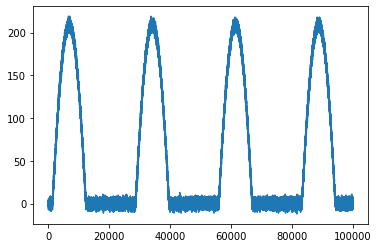

In [19]:
# Haciendo una sucesión de pulsos con ruido
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
waveform = ((pulses * 300) + noise).astype(np.int16)
plt.plot(waveform)

Ahora intentemos completar el cuerpo de esta ufunc:

In [0]:
@vectorize(['int16(int16, int16)'], target='cuda')
def zero_suppress(waveform_value, threshold):
    ### Reepmlaza esta implementación con la tuya
    result = waveform_value
    ###
    return result

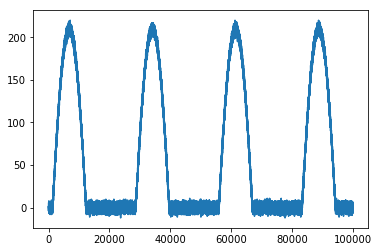

In [0]:
# El ruido de base deberái desaparecer cuando zero_suppress esté implementada
plt.plot(zero_suppress(waveform, 15.0))